In [1]:
!pip install torch torchvision faiss-cpu pillow transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 12.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np
import faiss
import os
from transformers import CLIPProcessor, CLIPModel

In [3]:
# Sample code to download images
import requests
img_urls = [
    'https://unsplash.com/photos/red-poppy-blooms-in-a-field-of-wildflowers-C1tPtOon2SQ',
    'https://unsplash.com/photos/a-lion-lying-down-sohngDnKTf8',
    # add more URLs
]
os.makedirs("images", exist_ok=True)
for i, url in enumerate(img_urls):
    r = requests.get(url)
    with open(f'images/img_{i}.jpg', 'wb') as f:
        f.write(r.content)

In [4]:
preprocess = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.48145466, 0.4578275, 0.40821073],
                [0.26862954, 0.26130258, 0.27577711])
])

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

In [11]:
def get_image_features(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        features = model.get_image_features(**inputs)
    return features.cpu().numpy().flatten()

image_paths = ["images/img_0.jpg", "images/img_1.jpg"]  # update with your files
features_db = np.array([get_image_features(p) for p in image_paths])

In [12]:
features_db = features_db / np.linalg.norm(features_db, axis=1, keepdims=True)

In [14]:
dim = features_db.shape[1]
index = faiss.IndexFlatIP(dim)  # Inner product = cosine similarity on normalized vectors
index.add(features_db)

In [15]:
query_image_path = "images/img_1.jpg"  # Replace with your actual filename
query_feat = get_image_features(query_image_path)
query_feat = query_feat / np.linalg.norm(query_feat)

In [16]:
D, I = index.search(np.expand_dims(query_feat, axis=0), k=5)  # Get indices of top-5 matches
similar_image_paths = [image_paths[i] for i in I[0]]

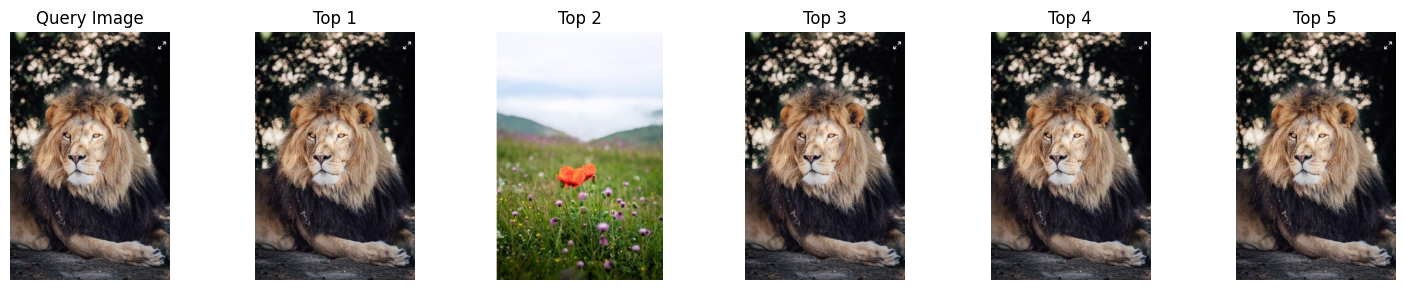

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.subplot(1, 6, 1)
plt.imshow(Image.open(query_image_path))
plt.title("Query Image")
plt.axis('off')

for idx, sim_path in enumerate(similar_image_paths):
    plt.subplot(1, 6, idx + 2)
    plt.imshow(Image.open(sim_path))
    plt.title(f"Top {idx + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()